# Example: Kernelized K-Nearest Neighbor Classification
In this example, we'll implement a K-nearest neighbor (KNN) classifier. We'll explore how features in the data, and different distance (kernel) functions can transform the feature space and impact the classifier's accuracy.


> __Learning Objectives:__
> 
> By the end of this example, you should be able to:
> 
> * __Apply the kernel trick__: Transform data using a kernel function to enable linear separation in a higher-dimensional space.
> * __Implement a kernelized KNN classifier__: Build and evaluate a KNN model that uses a custom kernel for similarity measurement.
> * __Analyze classifier performance__: Compute confusion matrices and error rates to assess the impact of different kernels.

Let's get started!
___

## Backstory: The Kernel Trick
The kernel trick is a clever technique in machine learning that allows algorithms to operate in high-dimensional feature spaces without explicitly computing the coordinates in that space. It enables linear classifiers to solve nonlinear problems by implicitly mapping data into a higher-dimensional space, making complex pattern analysis more computationally efficient.

* __The key insight__: Instead of explicitly transforming data to higher dimensions (which is expensive), we use kernel functions that compute similarities in the transformed space directly. For example, the RBF kernel $k(\mathbf{x},\mathbf{z}) = \exp(-\gamma\|\mathbf{x} - \mathbf{z}\|^2)$ implicitly maps data to an infinite-dimensional space where nonlinear patterns become linear.

* __Why this matters for KNN__: Traditional KNN uses Euclidean distance, which works well for linear patterns. Kernelized KNN uses similarity measures that can capture nonlinear relationships, potentially improving classification on complex datasets like our overlapping circular distributions.

__TLDR:__ You don't choose a feature mapping $\phi$! By choosing a (valid) functional form for the kernel $k$, you are indirectly (implicitly) assuming a feature map $\phi$. Thus, in a problem, when you iterate over functional forms for the $k$ function, each function gives a new _implicit_ feature mapping. Everything else stays the same.

___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

### Constants
Next, let's set some constants we'll need for the data generation logic below. Please look at the comment next to the constant for a description of what it is, permissible values, etc.

In [2]:
number_label_one = 1000; # number of points in cloud 1 (must be ≥ 2)
number_label_two = 1000; # number of points in cloud 2 (must be ≥ 2)
total_number_of_points = (number_label_one + number_label_two);
number_of_features = 3; # features: (x,y,l), where l is a generated label; see below.
c̄₁ = (0.0, 0.0); # center for the cloud: fixed
θ = 60*(π/180); # rotation angle (radians)

Finally, let's set up the color dictionary to visualize the classification datasets. The keys of the `my_color_dictionary::Dict Int64, RGB` dictionary class labels, i.e., $ y\in\{1,-1\}$ while the values are the colors mapped to that label.

In [3]:
my_color_dictionary = Dict{Int64,RGB}();
my_color_dictionary[1] = colorant"#03045e"; # color for Label = 1
my_color_dictionary[-1] = colorant"#e36414"; # color for Label = -1

### Implementation
The `fixedcircle` function generates data points that lie exactly on a circle around a specified center point. This creates a deterministic circular pattern useful for testing algorithms on known geometric shapes.

In [4]:

"""
    fixedcircle(center::Tuple{Float64,Float64}; number_of_points::Int = 100, radius::Float64 = 1.0) -> Array{Float64,2}

Generate random data points around a center point that lie on a circle.

### Arguments
- `center::Tuple{Float64,Float64}`: The center point around which the data points will be generated.
- `number_of_points::Int = 100`: The number of data points to generate.
- `radius::Float64 = 1.0`: The radius of the circle around the center point. Default value is 1.0.

### Returns
- A 2D array of data points. The first two columns are the x and y coordinates of the data points.
"""
function fixedcircle(center::Tuple{Float64,Float64}; 
    number_of_points::Int = 100, radius::Float64 = 1.0)::Array{Float64,2}

    # initialize -
    data = zeros(number_of_points, 2);
    θ = range(0, 2π, length=number_of_points);

    # generate the data -
    for i ∈ 1:number_of_points
        # generate random data points -
        data[i,1] = center[1] + radius * cos(θ[i]); # x
        data[i,2] = center[2] + radius * sin(θ[i]); # y
    end

    # return -
    return data;
end;

The `generatedatacloud` function creates random data points within an annular region (ring-shaped area) between two radii around a center point, each assigned a specific label. This generates overlapping circular distributions that are not linearly separable.

In [5]:
"""
    generatedatacloud(center::Tuple{Float64,Float64}; number_of_points::Int = 100, radius::Float64 = 1.0, label::Int64 = 1) -> Array{Float64,2}

Generate random data points around a center point that have a label, and radius less than equal to the given radius.

### Arguments
- `center::Tuple{Float64,Float64}`: The center point around which the data points will be generated.
- `number_of_points::Int = 100`: The number of data points to generate.
- `radius::Float64 = 1.0`: The radius of the circle around the center point. Default value is 1.0.
- `label::Int64 = 1`: The label to assign to the data points. Default value is 1.

### Returns
- A 2D array of data points. The first two columns are the x and y coordinates of the data points, and the third column is the label.
"""
function generatedatacloud(center::Tuple{Float64,Float64}; 
    number_of_points::Int = 100, r₁::Float64 = 1.0, r₂::Float64 = 2.0, label::Int64 = 1)::Array{Float64,2}

    # initialize -
    data = zeros(number_of_points, 3);

    # generate the data -
    for i ∈ 1:number_of_points
        
        θ = rand() * 2π; # random angle
        l = rand();
        r = (1-l)*r₁ + l*r₂ # random radius

        # generate random data points -
        data[i,1] = center[1] + r * cos(θ); # x
        data[i,2] = center[2] + r * sin(θ); # y
        data[i,3] = label; # label
    end

    # return -
    return data;
end;

### Data
We'll use [K-nearest neighbor classification](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) to classify datasets, including [the XOR dataset](https://en.wikipedia.org/wiki/Exclusive_or) that we construct. First, we'll generate a master dataset (which may or may not be linearly separable), then split it into (random) `training` and `test` subsets.
* __Training data__: Training datasets are collections of labeled data used to teach machine learning models, allowing these tools to learn patterns and relationships within the data. In our case, we'll use the training data to estimate the classifier parameters $\beta$.
* __Test data__: Test datasets, on the other hand, are separate sets of labeled data used to evaluate the performance of trained models on unseen examples, providing an unbiased assessment of the _model's generalization capabilities_.

Let's start by generating the master dataset `D::Array{Float64,2}`. This dataset will have two continuous features $\mathbf{x}\in\mathbb{R}^{2}$ and a categorical label $y\in\{-1,1\}$ and will be stored in the `D::Array{Float64,2}` variable:

In [6]:
D = let
    
    # initialize -
    D = Array{Float64,2}(undef, total_number_of_points, number_of_features);
    s₁ = generatedatacloud(c̄₁, number_of_points = number_label_one, label=1, r₁ = 0.0, r₂ = 1.0); # generate label 1 data
    s₂ = generatedatacloud(c̄₁, number_of_points = number_label_two, label=-1, r₁ = 2.0, r₂ = 3.0); # generate label 2 data

    # mix s₁, s₂ together (randomly)
    tmp = vcat(s₁,s₂)
    random_perm_index_vector = randperm(total_number_of_points);
    for i ∈ eachindex(random_perm_index_vector)
        k = random_perm_index_vector[i]; # get the from col -
        for j ∈ 1:number_of_features
            D[i,j] = tmp[k,j];
        end
    end

    # Finally, let's rotate the data a bit (counter-clockwise)
    R = [
        cos(θ) -sin(θ) ;
        sin(θ) cos(θ) ;
    ];

    # keep the label, but apply the rotation the (x,y) data
    D̂ = copy(D);
    for i ∈ 1:total_number_of_points
        x̂ = R*D[i,1:2];
        D̂[i,1] = x̂[1];
        D̂[i,2] = x̂[2];
    end
    
    D̂ # return the data
end;

#### Visualize dataset `D`
`Unhide` the code block below to see how we plotted the dataset `D`, which contains two continuous features and a label. The color indicates the label.

> __Summary__: We will get a different pattern of $\pm{1}$ labels depending on radius $r_{1}$ and $r_{2}$ values, and any additional labeling logic $L(x,y)$ we used. The dark blue dots represent label `1`, while the orange dots represent label `-1`. Our classifier should be able to learn the mapping between the features and the labels for linearly separable datasets.

So what do we see?

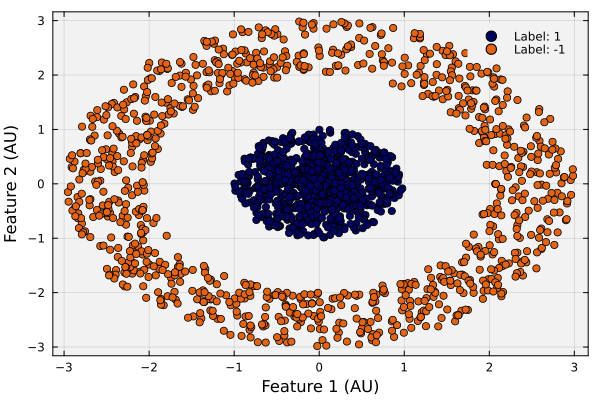

In [7]:
let

    dataset = D; # what dataset am I looking at?
    number_of_points_to_plot = size(dataset,1);
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot

    # plot label = 1
    testlabel = 1;
    i = findfirst(label -> label == testlabel,  dataset[:,3])
    c = my_color_dictionary[testlabel]
    scatter!([dataset[i,1]], [dataset[i,2]], label="Label: $(testlabel)", c=c)

    # plot label = -1
    testlabel = -1;
    i = findfirst(label -> label == testlabel,  dataset[:,3])
    c = my_color_dictionary[testlabel]
    scatter!([dataset[i,1]], [dataset[i,2]], label="Label: $(testlabel)", c=c)

    # plot all points
    for i ∈ 1:number_of_points_to_plot
        label = dataset[i,3]; # label
        c = my_color_dictionary[label]
        scatter!([dataset[i, 1]], [dataset[i, 2]], label="", mec=:navy, c=c)
    end
    
    xlabel!("Feature 1 (AU)", fontsize=18);
    ylabel!("Feature 2 (AU)", fontsize=18);
end

Next, let's split that dataset `D` into `training` and `test` subsets. We do this randomly, where the `number_of_training_examples::Int64` variable specifies the number of training points. The `training::Array{Float64,2}` data will be used to estimate the model parameters, and `test::Array{Float64,2}` will be used for model testing.

In [8]:
training, test = let

    number_of_training_examples = 1200; # we make this number of
    number_of_examples = total_number_of_points;
    full_index_set = range(1,stop=number_of_examples,step=1) |> collect |> Set;
    
    # build index sets for training and testing
    training_index_set = Set{Int64}();
    should_stop_loop = false;
    while (should_stop_loop == false)
        i = rand(1:number_of_examples);
        push!(training_index_set,i);

        if (length(training_index_set) == number_of_training_examples)
            should_stop_loop = true;
        end
    end
    test_index_set = setdiff(full_index_set,training_index_set);

    # build the test and train datasets -
    training = D[training_index_set |> collect,:];
    test = D[test_index_set |> collect,:];

    # return
    training, test
end;

___

## Task 1: K-Nearest Neighbor Classification
In this task, we'll set up a K-nearest neighbor (KNN) classification for different datasets generated in _task 1_. As part of this, we will look at different kernel functions (or different feature mappings $\phi$) to see how they impact classification performance.

> In the code cell below, build a kernel function $k:\mathbb{R}^{2}\times\mathbb{R}^{2}\to\mathbb{R}$ to measure similarity. You can use the [kernel exported by the `KernelFunctions.jl` package](https://juliagaussianprocesses.github.io/KernelFunctions.jl/stable/), or make one up on your own.

Let's save this function in the `k(x,y)::Function` variable.

In [9]:
k(x,y,p) = exp(-norm(x-y,p)^2) # RBF kernel with p-norm

k (generic function with 1 method)

#### Check: Are we using a valid Kernel function?
Let's check to see if the distance (similarity) metric we built is a valid kernel function.

> __Condition:__ A function $k:\mathbb{R}^{m}\times\mathbb{R}^{m}\to\mathbb{R}$ is a _valid kernel function_ if and only if the kernel matrix $\mathbf{K}\in\mathbb{R}^{n\times{n}}$ is positive (semi)definite for all possible choices of the data vectors $\mathbf{v}_i$, where $K_{ij} = k(\mathbf{v}_i, \mathbf{v}_j)$. If $\mathbf{K}$ is positive (semi)definite, for any real-valued vector $\mathbf{x}$, the Kernel matrix $\mathbf{K}$ must satisfy $\mathbf{x}^{\top}\mathbf{K}\mathbf{x} \geq 0$. 

Let's compute the kernel matrix `K::Array{Float64,2}` for a data matrix `X::Array{Float64,2}` using the distance/kernel function `k(x,y)::Function` we built above. 

In [10]:
K = let

    D₂ = test;
    number_of_test_examples = size(D₂,1);
    X = D₂[:,1:end-1]; # data for test (notice no extra 1)
    K = zeros(number_of_test_examples,number_of_test_examples);

    for i ∈ 1:number_of_test_examples
        vᵢ = X[i,:];
        for j ∈ 1:number_of_test_examples
            vⱼ = X[j,:];
            K[i,j] = k(vᵢ,vⱼ,1) # compute kernel value
        end
    end
    K
end;

Next, let's check to see if the kernel matrix `K::Array{Float64,2}` is positive (semi)definite by checking if all of its eigenvalues are non-negative.

> __Check__: For this kernel to be valid, the kernel matrix $\mathbf{K}$ needs to be positive (semi)definite. Let's check the condition: $\mathbf{x}^{\top}\,\mathbf{K}\,\mathbf{x}\geq{0}$ using [the `@assert` macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert).

Do we blow up? If not, then we have a valid kernel function!

In [11]:
let
    number_of_rows = size(K,1);
    x = randn(number_of_rows);
    @assert transpose(x)*K*x ≥ 0
end

### Inference

Now that we have defined a kernel function, let's use it to classify our data. We've implemented a KNN classifier in this repo. In the code block below, we:
* Construct [a `MyKNNClassificationModel` model](src/Types.jl) using a [custom `build(...)` method](src/Factory.jl). The `model` instance holds all the data for the problem, i.e., the how many neighbours to look at `K`, and the similarity function $d$.
* Next, we pass this `model` instance to [the `classify(...)` method](src/Compute.jl) which takes a test feature $\mathbf{z}$, the reference feature matrix $\mathbf{X}$ and label vector $\mathbf{y}$, and the classifier `model` instance and returns the predicted label value $\hat{y}$ for the test feature vector $\mathbf{z}$.

We return the predicted label in the `ŷ_KNN::Array{Int64,1}` array, and the actual label in the `y_KNN::Array{Int64,1}` array.

In [12]:
ŷ_KNN,y_KNN, model = let

    # Data -
    D₁ = training; # reference dataset 
    D₂ = test; # test
    number_of_training_examples = size(training,1);
    number_of_test_examples = size(test,1);
    X₁ = D₁[:,1:end-1]; # data for training (notice no extra 1)
    y₁ = D₁[:,end]; # label for training
    X₂ = D₂[:,1:end-1]; # data for test (notice no extra 1)
    y₂ = D₂[:,end]; # label for test
    ŷ₂ = zeros(number_of_test_examples);  # initialize some storage for the predicted label

    # build a model -
    model = build(MyKNNClassificationModel, (
        K = 101, # we look at this many points
        features = X₁,
        labels = y₁,
        d = (x,y) -> k(x,y,1), # some distance or similarity metric (replace with (x,y) -> k(x,y) for a kernel)
    ));

    # process each vector in the test set, and compare that to training (reference)
    for i ∈ 1:number_of_test_examples
        z = X₂[i,:]; # get feature vector for test
        ŷ₂[i] = classify(z,model) # classify the test vector using the training data
    end
 
    # return -
    ŷ₂,y₂,model
end;

### Performance 

We can evaluate the binary classifier's performance using various metrics. The central idea is to compare the predicted labels $\hat{y}_{i}$ to the actual labels $y_{i}$ in the `test` dataset and measure wins (when the label is the same) and losses (label is different). This is easily represented in [the confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).

> __Evaluation__ We compute confusion matrix [using the `confusion(...)` method](src/Compute.jl) and store it in the `CM_KNN::Array{Int64,2}` variable. The [`confusion(...)` method](src/Compute.jl) takes the actual labels and the computed labels and returns the confusion matrix.

What do we see?

In [13]:
CM_KNN = confusion(y_KNN,ŷ_KNN)

2×2 Matrix{Int64}:
 408    0
   0  392

Finally, we can compute the overall error rate for the KNN classifier (or other performance metrics) using values from [the confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). The [`confusion(...)` method](src/Compute.jl) takes the actual labels and the computed labels and returns the confusion matrix.

In [14]:
number_of_test_points = length(y_KNN);
correct_prediction_knn = CM_KNN[1,1] + CM_KNN[2,2];
(correct_prediction_knn/number_of_test_points) |> f-> println("Fraction correct: $(f) Fraction incorrect $(1-f)")

Fraction correct: 1.0 Fraction incorrect 0.0


### Visualize the misses
Using the `test` dataset, let's show (with white circles) which samples our classifier cannot predict the label correctly, i.e., where we miss the label. `Unhide` the code block below to see how we plotted the misclassified data points from the `test` dataset.

> __Summary__: When there is a clear boundary, the [KNN classifier](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) misses along the borders between classes (even for non-linearly separable data). However, when the data is randomly arranged, the [KNN classifier](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) cannot correctly assign the label.

Where are the misses?

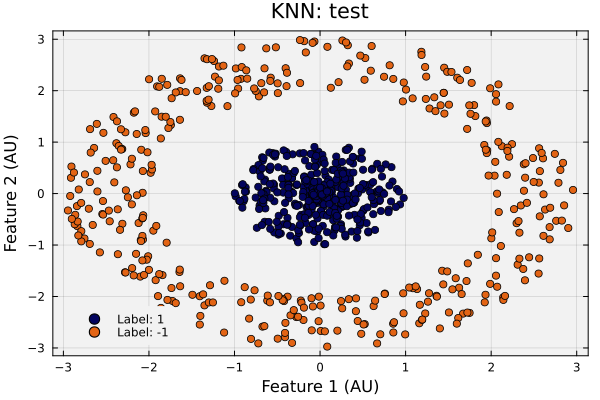

In [15]:
let

    dataset = test; # what dataset am I looking at?
    caselabel = "test";
    actual = y_KNN;
    predicted = ŷ_KNN;
    number_of_points = size(dataset,1); # number of rows
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot
    
    # plot label = 1
    testlabel = 1;
    i = findfirst(label -> label == testlabel,  dataset[:,3])
    c = my_color_dictionary[testlabel]
    scatter!([dataset[i,1]], [dataset[i,2]], label="Label: $(testlabel)", c=c)

    # plot label = -1
    testlabel = -1;
    i = findfirst(label -> label == testlabel,  dataset[:,3])
    c = my_color_dictionary[testlabel]
    scatter!([dataset[i,1]], [dataset[i,2]], label="Label: $(testlabel)", c=c)

    # data -
    for i ∈ 1:number_of_points
        actuallabel = actual[i]; # actual label
        testlabel = predicted[i]; # predited label

        c = :white;
        if (actuallabel == testlabel)
            c = my_color_dictionary[actuallabel]
        end
        scatter!([dataset[i, 1]], [dataset[i, 2]], label="", mec=:navy, c=c)
    end

    title!("KNN: $(caselabel)", fontsize=18)
    xlabel!("Feature 1 (AU)", fontsize=18);
    ylabel!("Feature 2 (AU)", fontsize=18);
end

___

## Task 2: Let's look at the neighborhood of a feature
In this task, we'll visualize the neighborhood of a feature vector used to estimate its label.
When we get counterintuitive results, it is helpful to see what the classifier sees, i.e., look at the neighborhood used to estimate the label. Let's pick a feature vector index, compute its neighborhood set $\mathcal{S}$, and visualize it.

In [16]:
î,z,yz = let

    # setup the data -
    D₁ = training; # reference dataset 
    D₂ = test; # test
    number_of_training_examples = size(training,1);
    number_of_test_examples = size(test,1);
    X₁ = D₁[:,1:end-1]; # data for training (notice no extra 1)
    y₁ = D₁[:,end]; # label for training
    X₂ = D₂[:,1:end-1]; # data for test (notice no extra 1)
    y₂ = D₂[:,end]; # label for test 

    # get feature vector -
    yz = 1;  # specify the label we want to see (1 = blue, -1 = orange)
    i = findall(s-> s == yz, y₂) |> collect |> rand # use some logic to select a point (random point label = yz)

    # Uncomment to see a misclassified point -
    # ismislabeled = Array{Bool,1}()
    # for i ∈ eachindex(ŷ_KNN)
    #     if (ŷ_KNN[i] == y_KNN && y_KNN[i] == yz)
    #         push!(ismislabeled,false)
    #     else
    #         push!(ismislabeled,true);
    #     end
    # end
    # i = findfirst(s -> s==true,ismislabeled);
    
    
    z = X₂[i,:]; # get the test feature
    

    # return
    i,z,yz
end

(200, [-0.143555404429331, 0.1807529074105782], 1)

Find the neighborhood $\mathcal{S}$: Each row containts the $(x,y)$ values, the label and the distance.

In [17]:
S = let

    # data -
    D₁ = training; # reference dataset 
    D₂ = test; # test
    number_of_training_examples = size(training,1);

    X₁ = D₁[:,1:end-1]; # data for training (notice no extra 1)
    y₁ = D₁[:,end]; # label for training
    X₂ = D₂[:,1:end-1]; # data for test (notice no extra 1)
    y₂ = D₂[:,end]; # label for test
    K = model.K;

    # compute the distances to all other reference points
    distances = zeros(number_of_training_examples);
    for i ∈ 1:number_of_training_examples
        xᵢ = X₁[i,:];
        distances[i] = model.d(z,xᵢ);
    end

     # sort the distances 
    sorted_indices = sortperm(distances, rev=true);

    # Get the top K points from the reference -
    number_of_features = size(X₁,2) # data for training (notice no extra 1)
    S = zeros(K,number_of_features+2)
    for i ∈ 1:K
        j = sorted_indices[i];
        vᵢ = X₁[j,:];
        yᵢ = y₁[j];
        dᵢ = distances[j];

        # package -
        for k ∈ 1:number_of_features
            S[i,k] = vᵢ[k]
        end
        S[i,number_of_features+1] = yᵢ
        S[i,number_of_features+2] = dᵢ
    end
    S
end;

__Visualize__: This plot shows the K nearest neighbors (solid colored points) for a selected test point (yellow star) overlaid on the full training dataset (faded points). The neighborhood reveals which training points influence the classification decision.

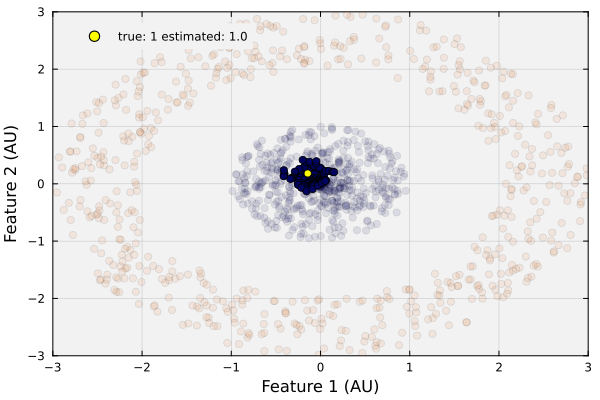

In [18]:
let

    X₁ = training[:,1:end-1]; # data for training (notice no extra 1)
    y₁ = training[:,end]; # label for training
    
    dataset = S[:,1:2];
    y = S[:,3];
    number_of_neighbor_points = size(dataset,1); # number of rows
    number_of_training_points = size(X₁,1); # number of rows
    
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, 
        fg_legend = :transparent, xlims=(-3,3), ylims=(-3,3)); # make an empty plot


    # plot all points -
    for i ∈ 1:number_of_training_points
        actuallabel = y₁[i]; # actual label
        c = my_color_dictionary[actuallabel]
        scatter!([X₁[i, 1]], [X₁[i, 2]], label="", mec=:navy, c=c, alpha=0.1)
    end
      
    # plot neighbors -
    for i ∈ 1:number_of_neighbor_points
        actuallabel = y[i]; # actual label
        c = my_color_dictionary[actuallabel]
        scatter!([S[i, 1]], [S[i, 2]], label="", mec=:navy, c=c)
    end
    current()

    # draw test point -
    c = :yellow
    scatter!([z[1]], [z[2]], label="true: $(yz) estimated: $(ŷ_KNN[î])", c=c, ms=4)
    
    xlabel!("Feature 1 (AU)", fontsize=18);
    ylabel!("Feature 2 (AU)", fontsize=18);
end

___

## Summary
This example demonstrates how kernel functions enable KNN classification to handle nonlinear decision boundaries by implicitly mapping data to higher-dimensional spaces.

> __Key Takeaways:__
> 
> * **Kernel trick enables nonlinear classification**: By using kernel functions instead of explicit distance metrics, KNN can solve nonlinear problems without computing high-dimensional coordinates.
> * **Kernel validity matters**: Kernel functions must be positive definite to ensure mathematical correctness and stable classification results.
> * **Neighborhood visualization aids understanding**: Examining the K nearest neighbors provides insight into how the classifier makes decisions for specific test points.

Kernelized KNN extends the basic KNN algorithm to handle complex pattern recognition tasks through implicit feature space transformations.